In [1]:
"""%load_ext autoreload
%autoreload 2
%load_ext wurlitzer
"""
import sys
import json
from ruamel.yaml import YAML
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import gc

import lossmaps as lm

from scipy.constants import c as clight

from cpymad.madx import Madx

import xpart as xp
import xtrack as xt
import xobjects as xo
import xdyna as xd
import xcoll as xc
# import xboinc as xb

No pytransport functionality
No pytransport functionality


In [2]:
# context = xo.ContextCpu(omp_num_threads=26)
context = xo.ContextCpu()
context.allow_prebuilt_kernels = False
context.allow_prebuilt_kernels

False

### Crystal Setup

In [3]:
#branch_name = 'main'
branch_name = 'NoMoreManager'
#branch_name = 'KayStatus'
#branch_name = 'ForKayAsSixtrack'
#branch_name = 'ForKayBetterEtaWithTransition'
#branch_name = 'ForKayBetterEtaWithoutTransition'

In [4]:
if branch_name in ['KayStatus', 'ForKayAsSixtrack', 'ForKayBetterEtaWithTransition', 'ForKayBetterEtaWithoutTransition']:
    coll = xc.EverestCrystal(length=0.002, material=xc.materials.SiliconCrystal, bending_angle=144e-6,
                            xdim=0.002, ydim=0.05, side='+', lattice='strip', jaw=0.001)
elif branch_name == 'main':
    coll = xc.EverestCrystal(length=0.002, material=xc.materials.SiliconCrystal, bending_angle=144e-6,
                            xdim=0.002, ydim=0.05, side='+', lattice='strip', jaw=0.001)
elif branch_name == 'NoMoreManager':
    coll = xc.EverestCrystal(length=0.002, material=xc.materials.SiliconCrystal, bending_angle=144e-6,
                            width=0.002, height=0.05, side='+', lattice='strip', jaw=0.001)

xp_crit_comp = 9.130328408646464e-06

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


### Tracking

In [5]:
tot_part = 0

for i in range(300):
    
    print('\nIteration: ', i, ",    range: ", (-50+i), ' , ',(-51+i), 'urad')
    num_part = int(3.33334e6)
    x_init   = np.random.normal(loc=1.5e-3, scale=75.e-6, size=num_part)
    px_init  = np.random.uniform(low=(-50+i)*1.e-6, high=(-51+i)*1.e-6, size=num_part)
    y_init   = np.random.normal(loc=0., scale=1e-6, size=num_part)
    py_init  = np.random.normal(loc=0., scale=1.e-8, size=num_part)
    part = xp.Particles(x=x_init, px=px_init, y=y_init, py=py_init, delta=0, p0c=4e11)

    del x_init, px_init, y_init, py_init
    gc.collect()

    part_init_px = part.px.copy().astype('float32')


    %time coll.track(part)
    # Sort particles again
    part.sort(interleave_lost_particles=True)

    alive = (part.state > 0 )
    df = pd.DataFrame({'px_in': part_init_px[alive], 'px_diff': part.px[alive].astype('float32') - part_init_px[alive]})
    mask =  (df.px_diff < 200.e-6) & ( df.px_diff > -75.e-6)

    del part, part_init_px
    gc.collect()

    # if i ==0:
    df[mask].to_hdf(Path( Path.cwd()/ 'slices', f'branch_{branch_name}_{-50+i}urad.h5'), key='px', format='table', mode='a',
                complevel=9, complib='blosc')
    # else:
    #     store = pd.HDFStore(Path(Path.cwd(), f'branch_{branch_name}_{-50+i}urad.h5'))
    #     store.append('px', df)
    #     store.close()
    
    tot_part += len(df)
    print('N part: ' ,len(df))
    
    del df
    gc.collect()


print('Total particles: ', tot_part)



Iteration:  0 ,    range:  -50  ,  -51 urad
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
CPU times: user 1.19 s, sys: 17.6 ms, total: 1.21 s
Wall time: 3.66 s
N part:  3318906

Iteration:  1 ,    range:  -49  ,  -50 urad
CPU times: user 1.15 s, sys: 0 ns, total: 1.15 s
Wall time: 1.15 s
N part:  3319140

Iteration:  2 ,    range:  -48  ,  -49 urad
CPU times: user 1.14 s, sys: 0 ns, total: 1.14 s
Wall time: 1.14 s
N part:  3319092

Iteration:  3 ,    range:  -47  ,  -48 urad
CPU times: user 1.19 s, sys: 0 ns, total: 1.19 s
Wall time: 1.19 s
N part:  3318950

Iteration:  4 ,    range:  -46  ,  -47 urad
CPU times: user 1.15 s, sys: 0 ns, total: 1.15 s
Wall time: 1.15 s
N part:  3319155

Iteration:  5 ,    range:  -45  ,  -46 urad
CPU times: user 1.21 s, sys: 0 ns, total: 1.21 s
Wall time: 1.21 s
N part:  3319037

Iteration:  6 ,    range:  -44  ,  -45 urad
CPU times: user 1.16 s, sys: 0 ns, total: 1.16 s
Wall time: 1.16 s
N part:  3319040

Iteration:  7 ,    range: 

In [6]:
print(coll.critical_angle)
print(coll.critical_angle == xp_crit_comp)

9.130328408646464e-06
False


In [7]:
df_part = pd.read_hdf(Path(Path.cwd(), f'branch_{branch_name}.h5'), key='px')
df_part

: 

In [ ]:
print('Check total particles:  ', tot_part == len(df_part))
del df_part
gc.collect()

Check total particles:   True


### Plotting

In [7]:
size = 1e8

if size == 1e9:
    df = pd.read_hdf(Path(Path.cwd(), f'branch_{branch_name}.h5'), key='px')
elif size == 1e8:
    df = pd.read_hdf(Path(Path.cwd(), f'branch_{branch_name}_veryreduced.h5'), key='px')

In [13]:
"""
print(len(df))
print(len(df.iloc[:-int(len(df)/2)]))

df.iloc[:-398960100].to_hdf(Path( Path.cwd(), f'branch_{branch_name}_veryreduced.h5'), key='px', format='table', mode='a',
                    complevel=9, complib='blosc')"""

In [6]:
len(df)


100000000

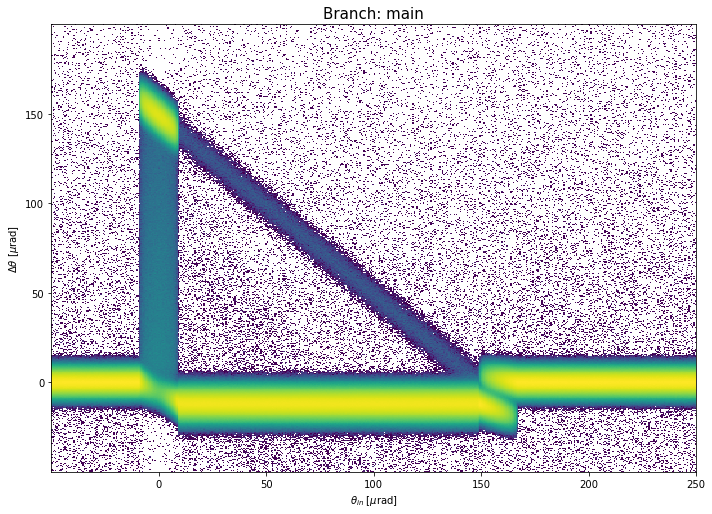

In [72]:
mask =  (df.part_px - df.part_init_px < 200.e-6) & ( df.part_px - df.part_init_px > -50.e-6) #


plt.figure(figsize=(10,7))

_ = plt.hist2d(df.part_init_px[mask]*1.e6, df.part_px[mask]*1.e6 - df.part_init_px[mask]*1.e6, 500, norm=mpl.colors.LogNorm())
#plt.xlim(-30, 180)
#plt.ylim(-55, 205)
plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
plt.tight_layout()
plt.title(f'Branch: {branch_name}', fontsize=15)
plt.savefig(f"Distribution_{branch_name}.png", dpi=300)

In [73]:
mask_zoom =  (df.part_px - df.part_init_px < 200.e-6) & ( df.part_px - df.part_init_px > 120.e-6) & (df.part_init_px > -10e-6) & (df.part_init_px < -7e-6) 


print("Scan.. ")
lower = -7.5
upper = -9.5
steps = np.linspace(lower, upper, -int((upper-lower)/0.1)+1)
lens = []
idx = 0
for i in steps:
    m = mask_zoom & (df.part_init_px > i*1.e-6) & (df.part_init_px < (i+0.1)*1.e-6)
    lens.append(len(df.part_px[m]))
    print('range: [', i, ', ', i+0.1, ']', lens[idx], lens[idx]-lens[idx-1] if idx > 0 else lens[idx])
    if lens[idx] <100 and lens[idx-1] > 100:
        lim_idx = idx-1
    idx += 1

print('\nFine in [', steps[lim_idx],', ', steps[lim_idx-1], ']')
lens_fine = []
idx = 0
fine_steps =  np.linspace(steps[lim_idx-1],steps[lim_idx], 11)
for i in fine_steps:
    print(i, i+0.01)
    m = mask_zoom & (df.part_init_px > i*1.e-6) & (df.part_init_px < (i+0.01)*1.e-6)
    lens_fine.append(len(df.part_px[m]))
    print('range: [', i, ', ', i+0.01, ']', lens_fine[idx], lens_fine[idx]-lens_fine[idx-1] if idx > 0 else lens[idx])
    if lens_fine[idx] <10 and lens_fine[idx-1] > 10:
        lim_idx_fine = idx-1
    idx += 1

print(fine_steps[lim_idx_fine-1], fine_steps[lim_idx_fine])

xp_crit = abs(np.mean(fine_steps[lim_idx_fine-1:lim_idx_fine+1]))*1e-6
print('\n\nxp_crit: ', xp_crit)




Scan.. 
range: [ -7.5 ,  -7.4 ] 14996 14996
range: [ -7.6 ,  -7.5 ] 14611 -385
range: [ -7.7 ,  -7.6000000000000005 ] 14351 -260
range: [ -7.8 ,  -7.7 ] 13654 -697
range: [ -7.9 ,  -7.800000000000001 ] 13222 -432
range: [ -8.0 ,  -7.9 ] 12490 -732
range: [ -8.1 ,  -8.0 ] 11870 -620
range: [ -8.2 ,  -8.1 ] 11286 -584
range: [ -8.3 ,  -8.200000000000001 ] 10703 -583
range: [ -8.4 ,  -8.3 ] 9715 -988
range: [ -8.5 ,  -8.4 ] 8969 -746
range: [ -8.6 ,  -8.5 ] 8264 -705
range: [ -8.7 ,  -8.6 ] 6924 -1340
range: [ -8.8 ,  -8.700000000000001 ] 5659 -1265
range: [ -8.9 ,  -8.8 ] 3988 -1671
range: [ -9.0 ,  -8.9 ] 803 -3185
range: [ -9.1 ,  -9.0 ] 1 -802
range: [ -9.2 ,  -9.1 ] 0 -1
range: [ -9.3 ,  -9.200000000000001 ] 2 2
range: [ -9.4 ,  -9.3 ] 4 2
range: [ -9.5 ,  -9.4 ] 1 -3

Fine in [ -9.0 ,  -8.9 ]
-8.9 -8.89
range: [ -8.9 ,  -8.89 ] 288 14996
-8.91 -8.9
range: [ -8.91 ,  -8.9 ] 233 -55
-8.92 -8.91
range: [ -8.92 ,  -8.91 ] 235 2
-8.93 -8.92
range: [ -8.93 ,  -8.92 ] 178 -57
-8.94 -8.93
r

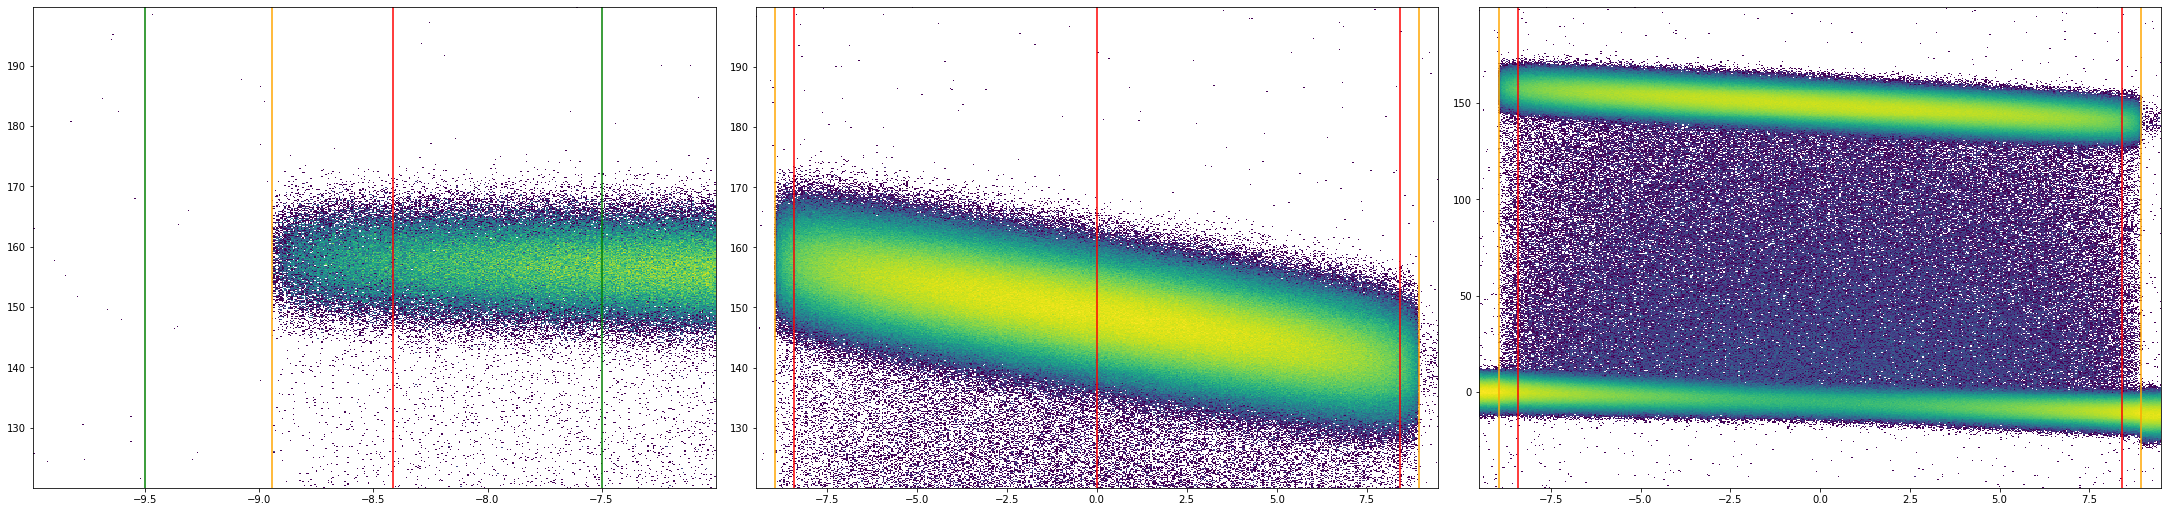

In [82]:
fig, ax= plt.subplots(1,3,layout='constrained',  figsize=(30,7))

_ = ax[0].hist2d(df.part_init_px[mask_zoom]*1.e6, df.part_px[mask_zoom]*1.e6 - df.part_init_px[mask_zoom]*1.e6, 500, norm=mpl.colors.LogNorm())

#plt.axvline(0, color='red')
#plt.axvline(xp_crit_comp*1.e6, color='red')
ax[0].axvline(-xp_crit_comp*1.e6, color='red')
ax[0].axvline(-9.5, color='g')
ax[0].axvline(-7.5, color='g')
ax[0].axvline(-xp_crit*1.e6, color='orange')


mask_zoom2 =  (df.part_px - df.part_init_px < 200.e-6) & ( df.part_px - df.part_init_px > 120.e-6) & (df.part_init_px > -9.5e-6) & (df.part_init_px < 9.5e-6) 

_ = ax[1].hist2d(df.part_init_px[mask_zoom2]*1.e6, df.part_px[mask_zoom2]*1.e6 - df.part_init_px[mask_zoom2]*1.e6, 500, norm=mpl.colors.LogNorm())

ax[1].axvline(0, color='red')
ax[1].axvline(xp_crit_comp*1.e6, color='red')
ax[1].axvline(-xp_crit_comp*1.e6, color='red')
ax[1].axvline(-xp_crit*1.e6, color='orange')
ax[1].axvline(xp_crit*1.e6, color='orange')

mask_zoom3 =  (df.part_px - df.part_init_px < 200.e-6) & ( df.part_px - df.part_init_px > -50.e-6) & (df.part_init_px > -9.5e-6) & (df.part_init_px < 9.5e-6) 
_ = ax[2].hist2d(df.part_init_px[mask_zoom3]*1.e6, df.part_px[mask_zoom3]*1.e6 - df.part_init_px[mask_zoom3]*1.e6, 500, norm=mpl.colors.LogNorm())
ax[2].axvline(xp_crit_comp*1.e6, color='red')
ax[2].axvline(-xp_crit_comp*1.e6, color='red')
ax[2].axvline(-xp_crit*1.e6, color='orange')
ax[2].axvline(xp_crit*1.e6, color='orange')




In [83]:
from scipy.optimize import curve_fit

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def fit(data):

    hist, bins = np.histogram(data, bins=100)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    initial_guess = [np.max(hist), np.mean(data), np.std(data)]
    popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=initial_guess)
    return popt

def fit_gaussian(data, ax, xlims = None):
  
    fit_data = fit(data)
    
    if xlims is None:
        xmin, xmax = ax.get_xlim()
    else:
        xmin, xmax = xlims[0], xlims[1]

    hist_values = np.array([rect.get_height() for rect in ax.patches])
    bin_edges = np.array([rect.get_x() for rect in ax.patches])

    hist_values = hist_values[np.where(bin_edges >= min(data))[0][0]:]
    bin_edges = [i for i in bin_edges if i >= min(data)]

    x = np.linspace(xmin, xmax, len(hist_values))

    # Calculate the area of the histogram
    bin_widths = np.diff(bin_edges)  
    bin_widths = np.append(bin_widths, 0) 
    hist_area = np.sum(hist_values * bin_widths) 

    tmp_y = gaussian(x, fit_data[0], fit_data[1], fit_data[2])
    funct_area = np.trapz(tmp_y, x=x)

    ax.plot(x, gaussian(x, fit_data[0]/funct_area*hist_area, fit_data[1], fit_data[2]), 'g', linestyle = '-', linewidth=2)
    print('mean: ', fit_data[1], 'std: ', fit_data[2])

mean:  0.00014897176137983932 std:  6.618857503464961e-06


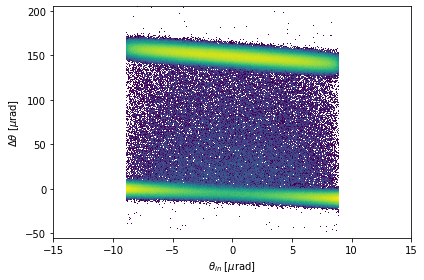

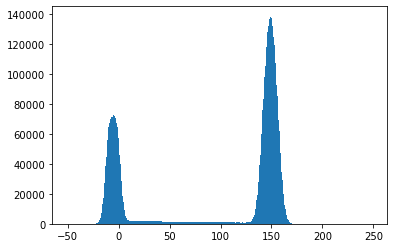

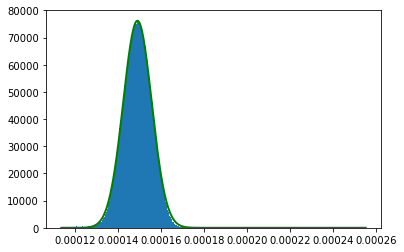

In [84]:
crit_ang_allowed = (df.part_init_px < xp_crit) & (df.part_init_px > -xp_crit) 
mask_ch = ( df.part_px - df.part_init_px < 250.e-6) & ( df.part_px - df.part_init_px > -50.e-6) & crit_ang_allowed
plt.figure()
_ = plt.hist2d(df.part_init_px[mask_ch]*1.e6, df.part_px[mask_ch]*1.e6 - df.part_init_px[mask_ch]*1.e6, 500, norm=mpl.colors.LogNorm())
plt.xlim(-15, 15)
plt.ylim(-55, 205)
plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
plt.tight_layout()

plt.figure()
_ = plt.hist(df.part_px[mask_ch]*1.e6 - df.part_init_px[mask_ch]*1.e6, bins=500,)

fig, ax = plt.subplots()
ang_defl  = df.part_px[mask_ch] - df.part_init_px[mask_ch]
fit_lim = 120e-6
fit_mask = ang_defl > fit_lim
ax.hist(ang_defl[fit_mask], 393)
fit_gaussian(ang_defl[fit_mask], ax)



mean:  0.00014897176137983932 std:  6.618857503464961e-06
Chann efficiency:  0.6444010191598296


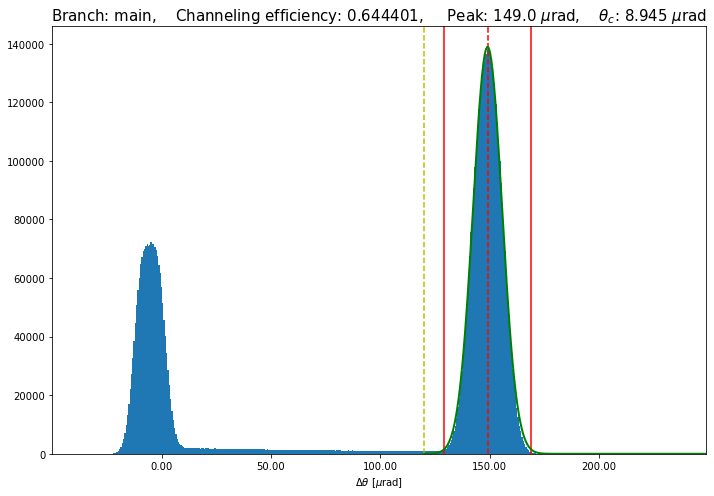

In [100]:
fig, ax = plt.subplots(figsize=(10,7))
_ = ax.hist(df.part_px[mask_ch] - df.part_init_px[mask_ch], 500)
ax.axvline(coll.bending_angle, color='r', linestyle='--')
ang_defl  = df.part_px[mask_ch] - df.part_init_px[mask_ch]
fit_lim = 120e-6
fit_mask = ang_defl > fit_lim
fit_param = fit(ang_defl[fit_mask])
sig = fit_param[2]
peak = fit_param[1]
ax.axvline(fit_lim, color='y', linestyle='--')
ax.axvline((coll.bending_angle+3*sig), color='r')
ax.axvline((coll.bending_angle-3*sig), color='r')
fit_gaussian(ang_defl[fit_mask], ax, xlims = (fit_lim, max(ang_defl)))
ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e6:.{2}f}" for x_tick in ax.get_xticks()])
ch = len(ang_defl[(ang_defl>coll.bending_angle-3*sig)&(ang_defl<coll.bending_angle+3*sig)])
print("Chann efficiency: ", ch/len(ang_defl))
ax.set_title(f'Branch: {branch_name},    Channeling efficiency: {ch/len(ang_defl):.6f},     Peak: {peak*1e6:.4}'+r' $\mu$rad'+r',    $\theta_c$:'+f' {xp_crit*1e6:.4}'+r' $\mu$rad',  fontsize=15)
ax.set_xlim(min(ang_defl), max(ang_defl))
# ax.set_xlim(min(data[m]), max(data[m]))
ax.set_xlabel(r'$\Delta\theta$ [$\mu$rad]')
fig.tight_layout()
fig.savefig(f"Channeling_efficiency_{branch_name}.png", dpi=300)

chann efficiency 
- MAIN: 0.6696088550379043
- NOMOREMANAGER: 0.5925642213275377

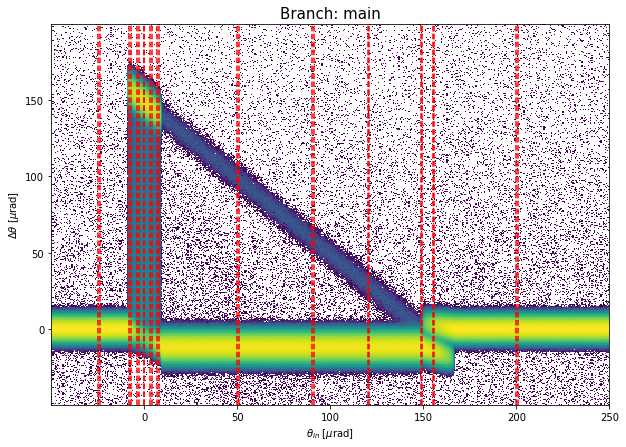

In [97]:
plt.figure(figsize=(10,7))
x = df.part_init_px[mask]*1.e6
y = df.part_px[mask]*1.e6 - df.part_init_px[mask]*1.e6
slices = [[-0.001, 0.001, 'CH_0'], [50, 51, 'VR'], [155, 156, 'TR VR-AM_2'], [3, 4, 'CH'], [-4, -3, 'CH'], [7,8, 'CH'], [-8, -7, 'CH'], [-25, -24, 'AM_1'], 
            [90, 91, 'VR'], [200, 201, 'AM_2'], [148.5, 149.5, 'TR'], [120,121, 'VR']]

slices = sorted(slices)
_ = plt.hist2d(x, y, 500, norm=mpl.colors.LogNorm())
for sl in slices:
    plt.axvline(sl[0], color = 'r', linestyle='--')
    plt.axvline(sl[1], color = 'r', linestyle='--')
plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
plt.title(f'Branch: {branch_name}', fontsize=15)
#plt.tight_layout()
plt.savefig(f"Slices_2d_{branch_name}.png", dpi=300)

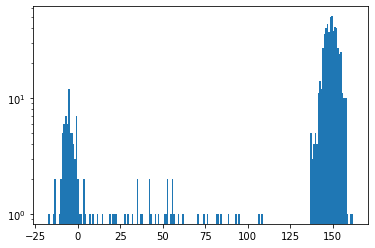

In [96]:
#m = (x > -1e-3) & (x < 1e-3)
m  = (x > -0.001) & (x < 0.001)
_ = plt.hist(y[m], 200)
plt.yscale('log')

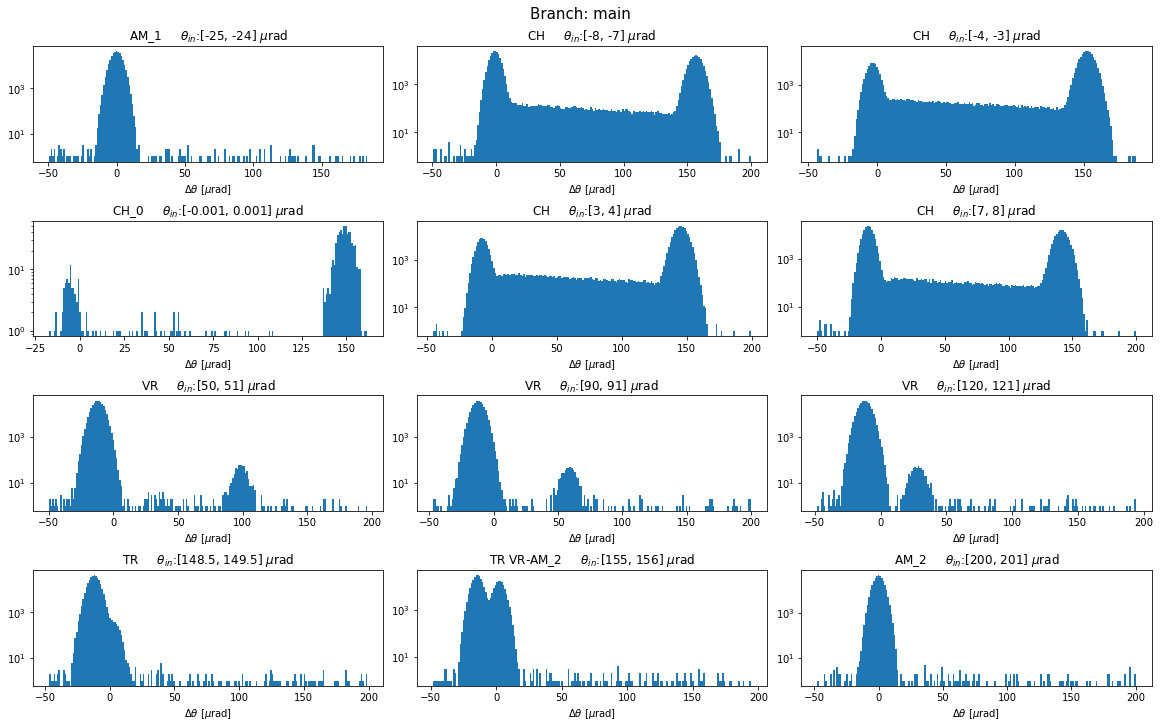

In [98]:
fig, ax= plt.subplots(4,3,layout='constrained',  figsize=(16,10))

for idx, a in enumerate(slices):  #[70, 90, 110, 130, 150.8, 170, 190, 210, 230,  250, 270]
    this_ax = ax[idx//3, idx%3]
    m = (x > slices[idx][0]) & (x < slices[idx][1])
    this_ax.hist(y[m], 200)
    this_ax.set_yscale('log')
    this_ax.set_title(f'{slices[idx][2]}'+ r'     $\theta_{in}$:' +f'[{slices[idx][0]}, {slices[idx][1]}' + r'] $\mu$rad')
    this_ax.set_xlabel(r'$\Delta\theta$ [$\mu$rad]')

fig.suptitle(f'Branch: {branch_name}',  fontsize=15)
fig.savefig(f"Slices_1d_{branch_name}.png", dpi=300)
    

In [ ]:
"""# OLD VERSION

mask =  (part.state > 0 )  & ( part.px - part_init.px < 200.e-6) & ( part.px - part_init.px > -50.e-6) # (part.state > 0 ) & ( part.px - part_init.px < 250.e-6) & ( part.px - part_init.px > -50.e-6) #& mask2
# mask = (part.state > 0 ) & mask2

# plt.figure(figsize=(5,10/3))
plt.figure(figsize=(10,7))
# _ = plt.hist2d(part_init.px[mask], (part.px[mask] - part_init.px[mask])/np.sqrt((150.e-6-part_init.px[mask])*1.75e-3/130.e-6), 200, norm=mpl.colors.LogNorm())


_ = plt.hist2d(part_init.px[mask]*1.e6, part.px[mask]*1.e6 - part_init.px[mask]*1.e6, 500, norm=mpl.colors.LogNorm())
#plt.xlim(-30, 180)
#plt.ylim(-55, 205)
plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
plt.tight_layout()
plt.title(f'Branch: {branch_name}', fontsize=15)
plt.savefig(f"Distribution_{branch_name}.png", dpi=300)"""

In [ ]:
"""# OLD VERSION

crit_ang_allowed = (part_init.px < xp_crit) & (part_init.px > -xp_crit) 
mask_ch = (part.state > 0 ) & ( part.px - part_init.px < 250.e-6) & ( part.px - part_init.px > -50.e-6) & crit_ang_allowed
plt.figure()
_ = plt.hist2d(part_init.px[mask_ch]*1.e6, part.px[mask_ch]*1.e6 - part_init.px[mask_ch]*1.e6, 500, norm=mpl.colors.LogNorm())
plt.xlim(-15, 15)
plt.ylim(-55, 205)
plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
plt.tight_layout()

plt.figure()
_ = plt.hist(part.px[mask_ch]*1.e6 - part_init.px[mask_ch]*1.e6, bins=500,)

fig, ax = plt.subplots()
ang_defl  = part.px[mask_ch] - part_init.px[mask_ch]
fit_lim = 120e-6
fit_mask = ang_defl > fit_lim
ax.hist(ang_defl[fit_mask], 393)
fit_gaussian(ang_defl[fit_mask], ax)

"""

In [ ]:
"""# OLD VERSION

fig, ax = plt.subplots(figsize=(10,7))
_ = ax.hist(part.px[mask_ch] - part_init.px[mask_ch], 500)
ax.axvline(coll.bending_angle, color='r', linestyle='--')
ang_defl  = part.px[mask_ch] - part_init.px[mask_ch]
fit_lim = 120e-6
fit_mask = ang_defl > fit_lim
fit_param = fit(ang_defl[fit_mask])
sig = fit_param[2]
peak = fit_param[1]
ax.axvline(fit_lim, color='y', linestyle='--')
ax.axvline((coll.bending_angle+3*sig), color='r')
ax.axvline((coll.bending_angle-3*sig), color='r')
fit_gaussian(ang_defl[fit_mask], ax, xlims = (fit_lim, max(ang_defl)))
ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e6:.{2}f}" for x_tick in ax.get_xticks()])
ch = len(ang_defl[(ang_defl>coll.bending_angle-3*sig)&(ang_defl<coll.bending_angle+3*sig)])
print("Chann efficiency: ", ch/len(ang_defl))
ax.set_title(f'Branch: {branch_name},    Channeling efficiency: {ch/len(ang_defl):.6f},     Peak: {paek*1e6:.4}'+r'$\mu$rad',  fontsize=15)

ax.set_xlim(min(ang_defl), max(ang_defl))
# ax.set_xlim(min(data[m]), max(data[m]))
ax.set_xlabel(r'$\Delta\theta$ [$\mu$rad]')
fig.tight_layout()

fig.savefig(f"Channeling_efficiency_{branch_name}.png", dpi=300)"""

In [ ]:
"""# OLD VERSION

plt.figure(figsize=(10,7))

x = part_init.px[mask]*1.e6
y = part.px[mask]*1.e6 - part_init.px[mask]*1.e6

slices = [[-0.5, 0.5, 'CH_0'], [50, 51, 'VR'], [155, 156, 'TR VR-AM_2'], [3, 4, 'CH'], [-4, -3, 'CH'], [7,8, 'CH'], [-8, -7, 'CH'], [-25, -24, 'AM_1'], 
            [90, 91, 'VR'], [200, 201, 'AM_2'], [148.5, 149.5, 'TR'], [120,121, 'VR']]


slices = sorted(slices)

_ = plt.hist2d(x, y, 500, norm=mpl.colors.LogNorm())

for sl in slices:
    plt.axvline(sl[0], color = 'r', linestyle='--')
    plt.axvline(sl[1], color = 'r', linestyle='--')
plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
plt.title(f'Branch: {branch_name}', fontsize=15)
#plt.tight_layout()

plt.savefig(f"Slices_2d_{branch_name}.png", dpi=300)
"""

In [2]:
import sys

# Example object
example_object = [1, 2, 3, 4, 5]

# Get the size of the object
size = sys.getsizeof(example_object)

# Print the size
print(f'The object uses {size} bytes of memory.')

The object uses 120 bytes of memory.


In [3]:
import sys

def get_total_size(obj, seen=None):
    """Recursively find the total memory size of an object."""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_total_size(v, seen) for v in obj.values()])
        size += sum([get_total_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_total_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_total_size(i, seen) for i in obj])
    return size

# Example object
example_object = [1, 2, 3, 4, 5]

# Get the total size of the object
total_size = get_total_size(example_object)

# Print the total size
print(f'The total memory usage of the object is {total_size} bytes.')

The total memory usage of the object is 260 bytes.


In [11]:
sys.getsizeof(df)/ (1024 ** 2)


1525.878921508789

In [10]:
get_total_size(example_object)

260

In [3]:
import subprocess
import os

In [8]:
file_list = os.listdir('./slices')
file_list = [f for f in file_list if branch_name in f]
files = {}
for file in file_list:
    files[int(file.split('_')[-1].split('u')[0])-1] = file

In [9]:
files

{-51: 'branch_main_-50urad.h5',
 -50: 'branch_main_-49urad.h5',
 -49: 'branch_main_-48urad.h5',
 -48: 'branch_main_-47urad.h5',
 -47: 'branch_main_-46urad.h5',
 -46: 'branch_main_-45urad.h5',
 -45: 'branch_main_-44urad.h5',
 -44: 'branch_main_-43urad.h5',
 -43: 'branch_main_-42urad.h5',
 -42: 'branch_main_-41urad.h5',
 -41: 'branch_main_-40urad.h5',
 -40: 'branch_main_-39urad.h5',
 -39: 'branch_main_-38urad.h5',
 -38: 'branch_main_-37urad.h5',
 -37: 'branch_main_-36urad.h5',
 -36: 'branch_main_-35urad.h5',
 -35: 'branch_main_-34urad.h5',
 -34: 'branch_main_-33urad.h5',
 -33: 'branch_main_-32urad.h5',
 -32: 'branch_main_-31urad.h5',
 -31: 'branch_main_-30urad.h5',
 -30: 'branch_main_-29urad.h5',
 -29: 'branch_main_-28urad.h5',
 -28: 'branch_main_-27urad.h5',
 -27: 'branch_main_-26urad.h5',
 -26: 'branch_main_-25urad.h5',
 -25: 'branch_main_-24urad.h5',
 -24: 'branch_main_-23urad.h5',
 -23: 'branch_main_-22urad.h5',
 -22: 'branch_main_-21urad.h5',
 -21: 'branch_main_-20urad.h5',
 -20: 'b

In [10]:
def load(low_lim, high_lim = None, files=files, perc = 1):
    

    with pd.HDFStore(Path(Path.cwd(), 'slices', files[low_lim]), 'r') as store:
        total_rows = store.get_storer('px').nrows
    store.close()
    rows_to_read = int(total_rows * perc)
    df = pd.read_hdf(Path(Path.cwd(), 'slices', files[low_lim]), key='px', start=0, stop=rows_to_read)

    if high_lim is not None:
        for i in range(low_lim+1, high_lim):
            with pd.HDFStore(Path(Path.cwd(), 'slices', files[i]), 'r') as store:
                total_rows = store.get_storer('px').nrows
            store.close()
            rows_to_read = int(total_rows * perc)
            df = pd.concat([df, pd.read_hdf(Path(Path.cwd(), 'slices', files[i]), key='px', start=0, stop=rows_to_read)])

    return df

Text(0.5, 0.98, 'Branch: main')

<Figure size 720x504 with 0 Axes>

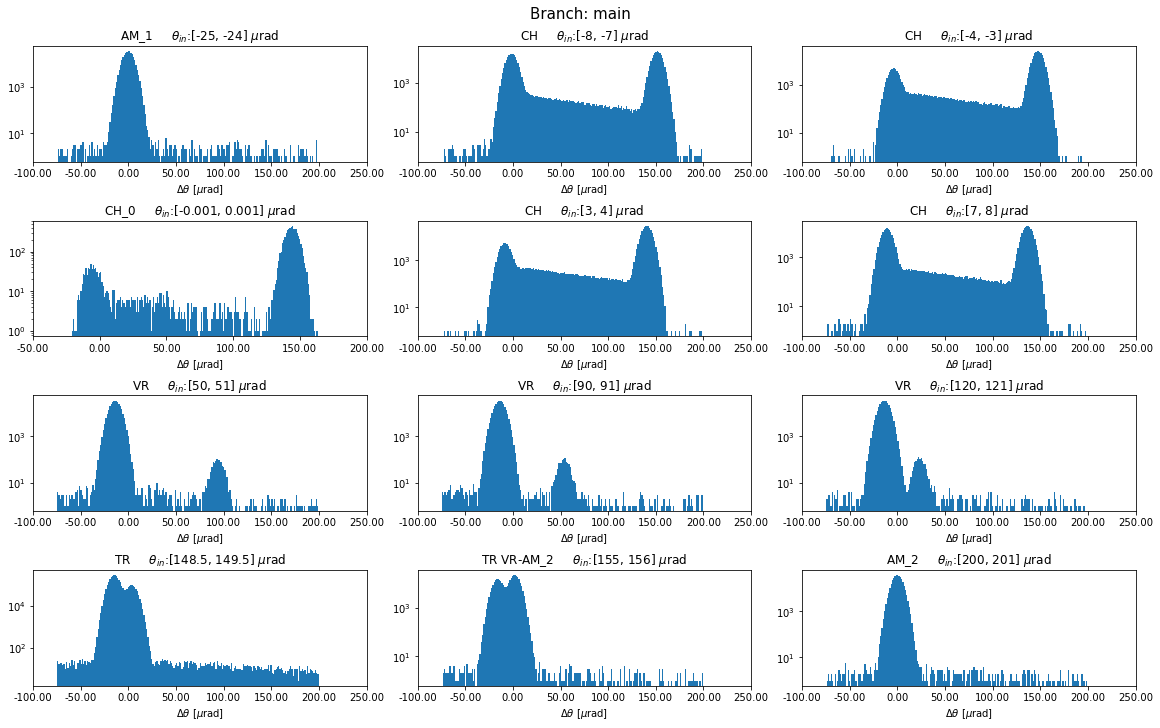

In [84]:

plt.figure(figsize=(10,7))

slices = [[-0.001, 0.001, 'CH_0'], [50, 51, 'VR'], [155, 156, 'TR VR-AM_2'], [3, 4, 'CH'], [-4, -3, 'CH'], [7,8, 'CH'], [-8, -7, 'CH'], [-25, -24, 'AM_1'], 
            [90, 91, 'VR'], [200, 201, 'AM_2'], [148.5, 149.5, 'TR'], [120,121, 'VR']]

slices = sorted(slices)
fig, ax= plt.subplots(4,3,layout='constrained',  figsize=(16,10))

for idx, a in enumerate(slices):  
    this_ax = ax[idx//3, idx%3]
    if slices[idx][0] in files.keys():
        df = load(slices[idx][0], perc=0.1)
        this_ax.hist(df.px_diff, 200)
    else:
        df = load(int(np.floor(slices[idx][0])), int(np.ceil(slices[idx][1])))
        mask = (df.px_in > slices[idx][0]*1e-6) & (df.px_in < slices[idx][1]*1e-6)
        this_ax.hist(df.px_diff[mask], 200)
    this_ax.set_xticks(ticks=this_ax.get_xticks(), labels=[f"{x_tick*1e6:.{2}f}" for x_tick in this_ax.get_xticks()])
    this_ax.set_yscale('log')
    this_ax.set_title(f'{slices[idx][2]}'+ r'     $\theta_{in}$:' +f'[{slices[idx][0]}, {slices[idx][1]}' + r'] $\mu$rad')
    this_ax.set_xlabel(r'$\Delta\theta$ [$\mu$rad]')

fig.suptitle(f'Branch: {branch_name}',  fontsize=15)
#fig.savefig(f"Slices_1d_{branch_name}.png", dpi=300)

In [90]:
del df
gc.collect()

287175

In [23]:
df = load(min(files.keys()), max(files.keys()), perc=0.2) 

In [24]:
plt.figure(figsize=(10,7))

_ = plt.hist2d(df.px_in*1.e6, df.px_diff*1.e6, 500, norm=mpl.colors.LogNorm())
#plt.xlim(-30, 180)
#plt.ylim(-55, 205)
plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
plt.tight_layout()
plt.title(f'Branch: {branch_name},    Particles in the plot: {len(df.px_in):.3e}', fontsize=15)
#plt.savefig(f"Distribution_{branch_name}.png", dpi=300)

: 

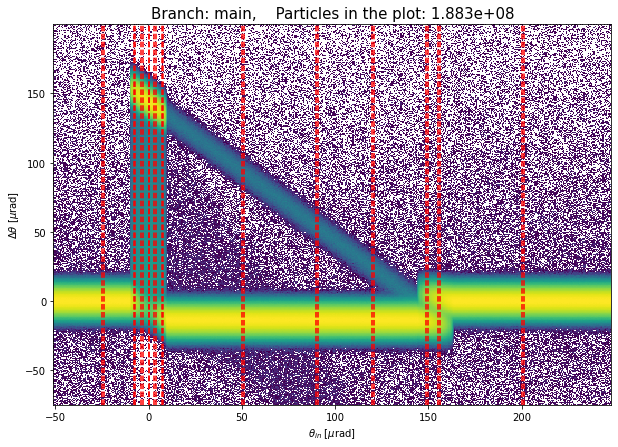

In [22]:
plt.figure(figsize=(10,7))

slices = [[-0.001, 0.001, 'CH_0'], [50, 51, 'VR'], [155, 156, 'TR VR-AM_2'], [3, 4, 'CH'], [-4, -3, 'CH'], [7,8, 'CH'], [-8, -7, 'CH'], [-25, -24, 'AM_1'], 
            [90, 91, 'VR'], [200, 201, 'AM_2'], [148.5, 149.5, 'TR'], [120,121, 'VR']]

slices = sorted(slices)
_ = plt.hist2d(df.px_in*1.e6, df.px_diff*1.e6,500, norm=mpl.colors.LogNorm())
for sl in slices:
    plt.axvline(sl[0], color = 'r', linestyle='--')
    plt.axvline(sl[1], color = 'r', linestyle='--')
plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
plt.title(f'Branch: {branch_name},    Particles in the plot: {len(df.px_in):.3e}', fontsize=15)
#plt.tight_layout()
#plt.savefig(f"Slices_2d_{branch_name}.png", dpi=300)